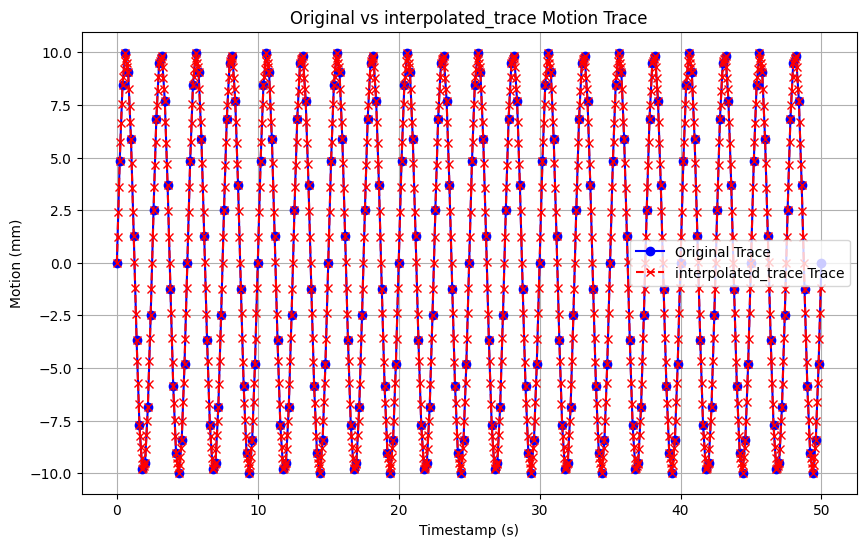

Interpolated trace saved as sine_wave_data_2.5s_10mm 50ms.txt


In [97]:
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
 
def interpolate_trace(input_file, output_file, new_interval=0.1, trace_name="interpolated_trace"):
    # Load the original motion trace data from the file
    data = pd.read_csv(input_file, sep=' ', header=None)
    # Check if it's a 2-column or 7-column trace
    if data.shape[1] == 2:
        # For 2-column file, assume [timestamp, motion]
        original_time = data[0].values
        original_motion = data[1].values
    elif data.shape[1] == 7:
        # For 7-column file, use [timestamp, motion] from 1st and 3rd columns
        original_time = data[0].values
        original_motion = data[2].values
    else:
        raise ValueError("Input file must have either 2 or 7 columns.")
 
    # Create new time intervals based on the desired interval
    min_time = np.min(original_time)
    max_time = np.max(original_time)
    new_time = np.arange(min_time, max_time, new_interval)
    # Perform interpolation
    interpolator = interpolate.interp1d(original_time, original_motion, kind='linear', fill_value='extrapolate')
    new_motion = interpolator(new_time)
    # Save the interpolated data to a new file
    interpolated_data = pd.DataFrame({'timestamp': new_time, 'motion': new_motion})
    interpolated_data.to_csv(output_file, sep=' ', header=False, index=False)
    # Plot the original and interpolated traces
    plt.figure(figsize=(10, 6))
    plt.plot(original_time, original_motion, label='Original Trace', marker='o', linestyle='-', color='b')
    plt.plot(new_time, new_motion, label=f'{trace_name} Trace', marker='x', linestyle='--', color='r')
    plt.xlabel('Timestamp (s)')
    plt.ylabel('Motion (mm)')
    plt.title(f'Original vs {trace_name} Motion Trace')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Interpolated trace saved as {output_file}")
 
# Example usage
input_file = 'sine_wave_data_2.5s_10mm 1.txt'  # Path to the original motion trace file
output_file = 'sine_wave_data_2.5s_10mm 50ms.txt'  # Path to save the new interpolated trace
interpolate_trace(input_file, output_file, new_interval=0.05, trace_name="interpolated_trace") # Define the trace timestamp interval (in s), define the new trace name

# Emulator
## Motion compensation simulation 
Integrating input motion reading, UDP sending and reading, multi-threading, latency, plotting input motion versus compensated motion 
## Wrap everything as a script
Read all input motion traces with different frequencies and amplitudes, and run through the same emulator parameters, compare the results
## Grid search
Given all sets of parameters and ask the emulator to run through all settings with the same trace.

In [66]:
import socket
import time
import struct
import threading
import numpy as np
import matplotlib.pyplot as plt
 
class MotionCompensationSimulator:
    def __init__(self, trace_file, latency=1.0,
                 local_ip="0.0.0.0", local_port=2400, target_ip="192.168.8.2", target_port=1400,
                 log_file="simulation_log.txt"):
 
        # Load input trace file: assumed to have [timestamp, y_position] per line
        self.timestamps = []
        self.true_motion = []
        with open(trace_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 2:
                    self.timestamps.append(float(parts[0]))
                    self.true_motion.append(float(parts[1]))
                elif len(parts) == 7:
                    self.timestamps.append(float(parts[0]))      # timestamp
                    self.true_motion.append(float(parts[2]))      # 3rd column (e.g., y_position)
 
        self.timestamps = np.array(self.timestamps)
        self.true_motion = np.array(self.true_motion)
 
        # Simulation parameters
        self.latency = latency  # In seconds
        self.cumulative_feedback = 0.0
        # Networking
        self.local_ip = local_ip
        self.local_port = local_port
        self.target_ip = target_ip
        self.target_port = target_port
 
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.sock.bind((self.local_ip, self.local_port))
        self.sock.settimeout(1.0)
 
        # Logging
        self.log_file_path = log_file
        self.log_lines = []
 
        # Shared feedback state
        self.feedback_queue = []  # stores (recv_time, value)
        self.feedback_applied = [0.0 for _ in self.timestamps]
        self.feedback_lock = threading.Lock()
        self.stop_flag = threading.Event()
 
    def feedback_listener(self): # Receive feedback from Pi. Log the received timestamp. 
                                 # Store the value in [timestamp, value] format, in self.feedback_queue
                                 # The feedback is applied to the original motion in timestamp order
        while not self.stop_flag.is_set():
            try:
                data, addr = self.sock.recvfrom(1024)
                if len(data) >= 8:
                    feedback_val = struct.unpack("d", data[:8])[0]
                    recv_time = time.time() - self.start_time
                    with self.feedback_lock:
                        self.feedback_queue.append((recv_time, feedback_val))
                    self.log_feedback(feedback_val, recv_time)
            except socket.timeout:
                continue
 
    def sender(self):
        self.start_time = time.time()
        start_time = self.start_time
        self.feedback_applied = [0.0 for _ in self.timestamps]
 
        for i, t in enumerate(self.timestamps): # Latency applied here
            while time.time() < start_time + t + self.latency:
                time.sleep(0.001)
 
            current_time = time.time() - start_time
 
            # Apply any feedback whose recv_time has passed
            with self.feedback_lock:
                unapplied = []
                for recv_time, val in self.feedback_queue:
                    for j in range(i + 1, len(self.timestamps)):
                        if self.timestamps[j] > recv_time:
                            self.feedback_applied[j] += val
                            break
                    else:
                        unapplied.append((recv_time, val))  # retain if not yet usable
                self.feedback_queue = unapplied
            self.cumulative_feedback += self.feedback_applied[i]
            corrected_y = self.true_motion[i] + self.cumulative_feedback # Original motion + couch compensation
            packed = struct.pack("d", corrected_y)
            self.sock.sendto(packed, (self.target_ip, self.target_port)) # Send the compensated position to Pi
 
            send_actual_time = time.time() - start_time
            self.log_lines.append(f"{t:.5f}\t{self.true_motion[i]:.4f}\t{corrected_y:.4f}\t{self.feedback_applied[i]:.4f}\t{send_actual_time:.5f}")
 
        self.stop_flag.set()
 
    def log_feedback(self, feedback_val, recv_time):
        with open(self.log_file_path.replace("simulation_log", "feedback_log"), "a") as f:
            f.write(f"{recv_time:.5f}\t{feedback_val:.6f}\n")
 
    def run_simulation(self):
        recv_thread = threading.Thread(target=self.feedback_listener, daemon=True)
        send_thread = threading.Thread(target=self.sender)
 
        recv_thread.start()
        send_thread.start()
 
        send_thread.join()
        recv_thread.join(timeout=2.0)
 
        self.sock.close()
        with open(self.log_file_path, "w") as f:
            f.write("Time\tOriginal_motion\tCompensated_motion(SentY)\tReceived_feedback\tActualSendTime\n")
            f.write("\n".join(self.log_lines))

    def evaluate_auc(self):

        times, true_y, sent_y = [], [], []
        with open(self.log_file_path, "r") as f:
            next(f)  # Skip header
            for line in f:

                t, ty, sy, *_ = map(float, line.strip().split())

                times.append(t)

                true_y.append(ty)

                sent_y.append(sy)

        times = np.array(times)
        true_y = np.array(true_y)
        sent_y = np.array(sent_y)
        delta_t = np.mean(np.diff(times))  # Assume uniform time steps
    
        auc_original = np.sum(np.abs(true_y)) * delta_t

        auc_compensated = np.sum(np.abs(sent_y)) * delta_t

        auc_diff = auc_original - auc_compensated

        reduction_ratio = 1 - (auc_compensated / auc_original)
    
        print(f"AUC Original:     {auc_original:.2f}")

        print(f"AUC Compensated: {auc_compensated:.2f}")

        print(f"Δ AUC:            {auc_diff:.2f} (Reduction: {reduction_ratio:.2%})")
    
        return {

            "auc_original": auc_original,

            "auc_compensated": auc_compensated,

            "auc_diff": auc_diff,

            "reduction_ratio": reduction_ratio

        }

 
 
    def plot_results(self):
        time_vals, true_y, sent_y, corrected_y = [], [], [], []
 
        with open(self.log_file_path, "r") as f:
            next(f)  # skip header
            for line in f:
                t, ty, sy, cy, *_ = map(float, line.strip().split())
                time_vals.append(t)
                true_y.append(ty)
                sent_y.append(sy)
                corrected_y.append(cy)
 
        residual_error = [ty - cy for ty, cy in zip(true_y, corrected_y)]
        '''
        times, fd = [],[]
        with open("feedback_log.txt", "r") as f:
            next(f)  # skip header
            for line in f:
                time, feedback, *_ = map(float, line.strip().split())
                times.append(time)
                fd.append(feedback)
        '''

        plt.figure(figsize=(10, 6))
        plt.plot(time_vals, true_y, label="Original Motion")
        plt.plot(time_vals, sent_y, label="Compensated motion", linestyle='--')
        
        #plt.scatter(times, fd, label="Couch feedback")
      
        plt.xlabel("Time (s)")
        plt.ylabel("Position (mm)")
        plt.title(f"Motion Compensation with {self.latency:.1f}s Tracking Latency")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
 
        print(f"Max Error: {max(abs(e) for e in residual_error):.2f} mm")
        print(f"RMS Error: {np.sqrt(np.mean(np.square(residual_error))):.2f} mm")

In [146]:
sim = MotionCompensationSimulator(trace_file="sine_wave_data_2.5s_10mm 10ms.txt", latency=0)
sim.run_simulation()
#sim.evaluate_auc()

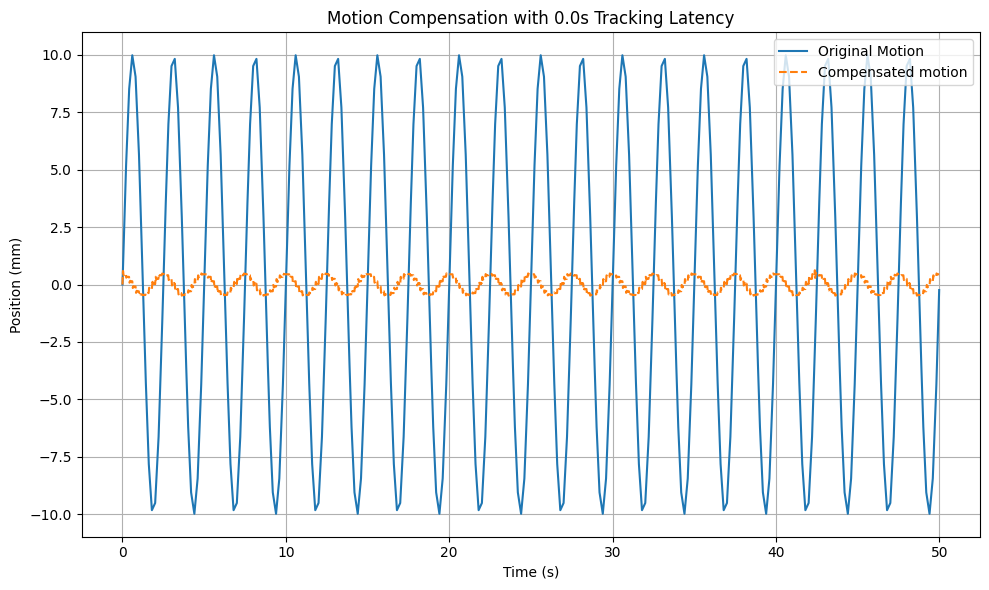

Max Error: 10.06 mm
RMS Error: 6.94 mm


In [147]:
sim.plot_results()

In [94]:
# Traces with different frequency test (0.05Hz, 0.1Hz, 0.2Hz, .... increasingly)
# Amplitude test 
# Put all traces in one folder, run through all traces and compare results 

import os

import pandas as pd

from time import sleep
 
def batch_run_and_collect_results(trace_folder, latency=1.0,

                                  local_port=2400, target_ip="192.168.8.2", target_port=1400):

    results = []
 
    for filename in os.listdir(trace_folder):

        if filename.endswith(".txt"):

            trace_path = os.path.join(trace_folder, filename)

            print(f"\n=== Running Simulation for {filename} ===")

            log_file = f"simulation_log_{filename.replace('.txt', '')}.txt"
 
            sim = MotionCompensationSimulator(

                trace_file=trace_path,

                latency=latency,

                local_port=local_port,

                target_ip=target_ip,

                target_port=target_port,

                log_file=log_file

            )
 
            sim.run_simulation()

            result = sim.evaluate_auc()

            result["trace_file"] = filename

            results.append(result)
 
            sleep(1.0)  # Optional: short pause between runs to avoid overlap or buffer issues
 
    # Convert to DataFrame

    df_results = pd.DataFrame(results)

    df_results.sort_values(by="auc_diff", ascending=False, inplace=True)
 
    return df_results

 

In [ ]:
df = batch_run_and_collect_results("path/to/trace_folder")
df.head()

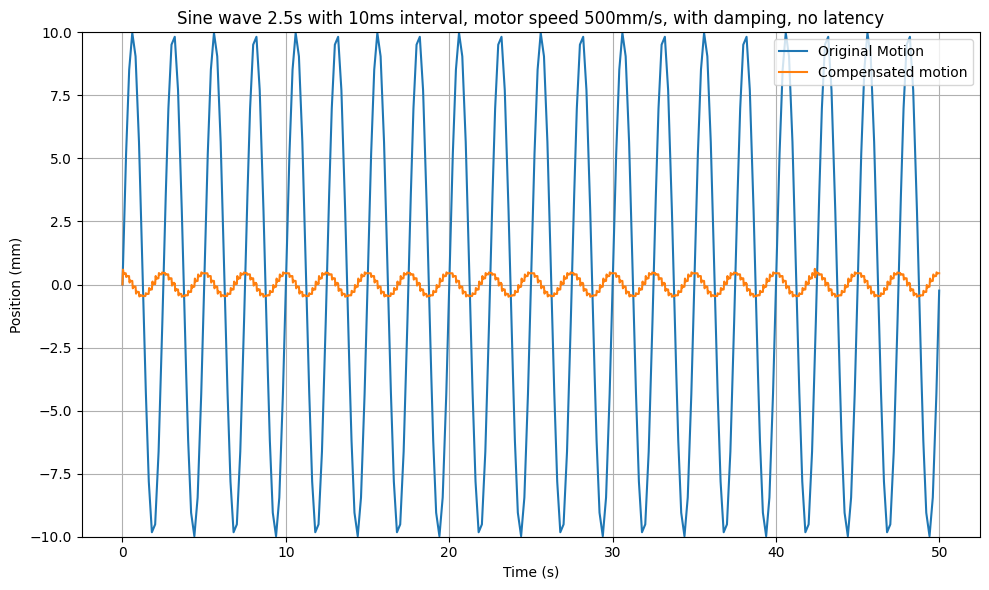

In [149]:
time_vals, true_y, sent_y, corrected_y = [], [], [], []
 
with open("simulation_log.txt", "r") as f:
    next(f)  # skip header
    for line in f:
        t, ty, sy, cy, *_ = map(float, line.strip().split())
        time_vals.append(t)
        true_y.append(ty)
        sent_y.append(sy)
        corrected_y.append(cy)
 
#residual_error = [ty - cy for ty, cy in zip(true_y, corrected_y)]
'''
times, fd = [],[]
with open("feedback_log.txt", "r") as f:
    next(f)  # skip header
    for line in f:
        time, feedback, *_ = map(float, line.strip().split())
        times.append(time)
        fd.append(feedback)
'''
plt.figure(figsize=(10, 6))
plt.plot(time_vals, true_y, label="Original Motion")
plt.plot(time_vals, sent_y, label="Compensated motion")
        # Filter out zero feedback values for plotting
#filtered_times = [t for t, f in zip(time_vals, corrected_y) if abs(f) > 1e-6]
#filtered_feedback = [f for f in corrected_y if abs(f) > 1e-6]
#plt.scatter(times, fd, label="Couch feedback")
        #plt.plot(time_vals, residual_error, label="Residual Error", linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Position (mm)")
plt.ylim(-10,10)
plt.title(f"Sine wave 2.5s with 10ms interval, motor speed 500mm/s, with damping, no latency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
 
#print(f"Max Error: {max(abs(e) for e in residual_error):.2f} mm")
#print(f"RMS Error: {np.sqrt(np.mean(np.square(residual_error))):.2f} mm")

## Combined and integrated emulator

In [150]:
import os
import socket
import time
import struct
import threading
import numpy as np
 
class Emulator:

    def __init__(self, trace_file, latency=1.0,

                 local_ip="0.0.0.0", local_port=2400, target_ip="192.168.8.2", target_port=1400,

                 output_dir="simulation_outputs"):

        self.trace_file = trace_file
        self.latency = latency
        self.local_ip = local_ip
        self.local_port = local_port
        self.target_ip = target_ip
        self.target_port = target_port
        self.output_dir = output_dir
        self.timestamps = []
        self.true_motion = []
 
        with open(trace_file, "r") as f:

            for line in f:
                parts = line.strip().split()

                if len(parts) == 2:

                    self.timestamps.append(float(parts[0]))

                    self.true_motion.append(float(parts[1]))

                elif len(parts) == 7:

                    self.timestamps.append(float(parts[0]))

                    self.true_motion.append(float(parts[2]))
 
        self.timestamps = np.array(self.timestamps)

        self.true_motion = np.array(self.true_motion)
 
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

        self.sock.bind((self.local_ip, self.local_port))

        self.sock.settimeout(1.0)
 
        self.feedback_queue = []

        self.feedback_applied = [0.0 for _ in self.timestamps]

        self.feedback_lock = threading.Lock()

        self.stop_flag = threading.Event()

        self.log_lines = []
 
    def feedback_listener(self):

        while not self.stop_flag.is_set():

            try:

                data, addr = self.sock.recvfrom(1024)

                if len(data) >= 8:

                    feedback_val = struct.unpack("d", data[:8])[0]

                    recv_time = time.time() - self.start_time

                    with self.feedback_lock:

                        self.feedback_queue.append((recv_time, feedback_val))

            except socket.timeout:

                continue
 
    def sender(self):

        self.start_time = time.time()

        start_time = self.start_time

        self.feedback_applied = [0.0 for _ in self.timestamps]
 
        for i, t in enumerate(self.timestamps):

            while time.time() < start_time + t + self.latency:

                time.sleep(0.001)
 
            with self.feedback_lock:

                unapplied = []

                for recv_time, val in self.feedback_queue:

                    for j in range(i + 1, len(self.timestamps)):

                        if self.timestamps[j] > recv_time:

                            self.feedback_applied[j] += val

                            break

                    else:

                        unapplied.append((recv_time, val))

                self.feedback_queue = unapplied
 
            corrected_y = self.true_motion[i] + sum(self.feedback_applied[:i+1])

            packed = struct.pack("d", corrected_y)

            self.sock.sendto(packed, (self.target_ip, self.target_port))
 
            send_actual_time = time.time() - start_time

            self.log_lines.append(f"{t:.5f}\t{self.true_motion[i]:.4f}\t{corrected_y:.4f}\t{self.feedback_applied[i]:.4f}\t{send_actual_time:.5f}")
 
        self.stop_flag.set()
 
    def run(self):

        recv_thread = threading.Thread(target=self.feedback_listener, daemon=True)

        send_thread = threading.Thread(target=self.sender)
 
        recv_thread.start()

        send_thread.start()
 
        send_thread.join()

        recv_thread.join(timeout=2.0)
 
        self.sock.close()
 
        os.makedirs(self.output_dir, exist_ok=True)

        base_name = os.path.splitext(os.path.basename(self.trace_file))[0]

        output_path = os.path.join(self.output_dir, f"{base_name}_simulated.txt")
 
        with open(output_path, "w") as f:

            f.write("Time\tOriginal_motion\tCompensated_motion(SentY)\tReceived_feedback\tActualSendTime\n")

            f.write("\n".join(self.log_lines))
 
        return output_path
 
# Batch runner function

def run_all_simulations(trace_folder, output_dir="simulation_outputs", latency=1.0):

    trace_files = [f for f in os.listdir(trace_folder) if f.endswith(".txt")]

    trace_paths = [os.path.join(trace_folder, f) for f in trace_files]
 
    output_files = []

    for trace_path in trace_paths:

        emulator = Emulator(trace_path, latency=latency, output_dir=output_dir)

        out_path = emulator.run()

        output_files.append(out_path)
 
    return output_files

 

In [ ]:
/motion_traces/
    trace1.txt
    trace2.txt
/gridsearch_results/
    trace1_G0.4_D0.1_S0.2.txt
    trace1_G0.4_D0.2_S0.2.txt
    trace2_G0.5_D0.3_S0.1.txt
    ...

In [ ]:
# Define the types and values of parameters to be tested 
parameter_ranges = {
    "gain": [0.2, 0.4, 0.6],
    "deadband": [0.0, 0.1],
    "smoothing": [0.0, 0.2]
}

In [ ]:
import itertools
import socket
import struct
import Emulator  # if in separate file
# or use directly if it's in the same notebook

# Sending the config values to Pi via UDP. 
# Keep the Pi code running all the time. Allow Pi running multiple trace simulation without restarting the code
def send_config_to_pi(gain, deadband, smoothing, ip="192.168.8.2", port=1500):
    config_packet = struct.pack("fff", gain, deadband, smoothing)
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(config_packet, (ip, port))
    sock.close()
 
def run_grid_search(trace_folder, output_dir, parameter_ranges, latency=1.0):
    gain_vals = parameter_ranges["gain"]
    deadband_vals = parameter_ranges["deadband"]
    smoothing_vals = parameter_ranges["smoothing"]
 
    trace_files = [f for f in os.listdir(trace_folder) if f.endswith(".txt")]
 
    for trace_file in trace_files:
        trace_path = os.path.join(trace_folder, trace_file)
        base_name = os.path.splitext(trace_file)[0]
 
        for gain, deadband, smoothing in itertools.product(gain_vals, deadband_vals, smoothing_vals):
            # Send param config to Pi
            send_config_to_pi(gain, deadband, smoothing)
 
            # Wait briefly to allow Pi to receive config
            time.sleep(0.3)
 
            # Construct filename
            out_name = f"{base_name}_G{gain:.2f}_D{deadband:.2f}_S{smoothing:.2f}.txt"
            out_path = os.path.join(output_dir, out_name)
 
            # Run simulation
            emulator = Emulator(trace_file=trace_path,
                                       latency=latency,
                                       output_dir=output_dir)
            emulator.run()